In [24]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
%matplotlib inline  

In [25]:
data = pd.read_csv(r"E:\data sci\Deep learning\SMS_Spam_Detection-master\spam.csv", encoding='latin-1')
data.head(n=10)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [26]:
count1 = Counter(" ".join(data[data['v1']=='ham']["v2"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in non-spam", 1 : "count"})
count2 = Counter(" ".join(data[data['v1']=='spam']["v2"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in spam", 1 : "count_"})

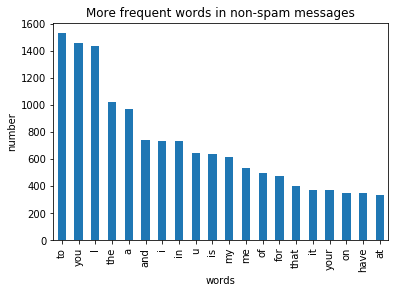

In [27]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in non-spam"]))
plt.xticks(y_pos, df1["words in non-spam"])
plt.title('More frequent words in non-spam messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

In [28]:
f = feature_extraction.text.TfidfVectorizer(stop_words = 'english')
X = f.fit_transform(data["v2"])
np.shape(X)

(5572, 8404)

In [29]:
data["v1"]=data["v1"].map({'spam':1,'ham':0})
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, data['v1'], test_size=0.33, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(3733, 8404), (1839, 8404)]


In [30]:
list_alpha = np.arange(1/100000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [31]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)


,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.00001,1.000000,0.973355,0.912698,0.894942
1,0.11001,0.998661,0.978249,0.920635,0.920635
2,0.22001,0.997589,0.981512,0.900794,0.961864
3,0.33001,0.994910,0.981512,0.888889,0.973913
4,0.44001,0.993571,0.978793,0.857143,0.986301
5,0.55001,0.992231,0.976074,0.829365,0.995238
6,0.66001,0.989821,0.976074,0.825397,1.000000
7,0.77001,0.985534,0.973355,0.805556,1.000000
8,0.88001,0.981248,0.968461,0.769841,1.000000
9,0.99001,0.978034,0.965742,0.750000,1.000000


In [32]:
best_index = models['Test Precision'].idxmax()

In [33]:
models.iloc[best_index, :]

alpha             0.660010
Train Accuracy    0.989821
Test Accuracy     0.976074
Test Recall       0.825397
Test Precision    1.000000
Name: 6, dtype: float64

In [34]:
models[models['Test Precision']==1].head(n=5)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
6,0.66001,0.989821,0.976074,0.825397,1.0
7,0.77001,0.985534,0.973355,0.805556,1.0
8,0.88001,0.981248,0.968461,0.769841,1.0
9,0.99001,0.978034,0.965742,0.750000,1.0
10,1.10001,0.975355,0.963567,0.734127,1.0


In [35]:
best_index = models[models['Test Precision']==1]['Test Accuracy'].idxmax()
bayes = naive_bayes.MultinomialNB(alpha=list_alpha[best_index])
bayes.fit(X_train, y_train)
models.iloc[best_index, :]

alpha             0.660010
Train Accuracy    0.989821
Test Accuracy     0.976074
Test Recall       0.825397
Test Precision    1.000000
Name: 6, dtype: float64

In [36]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1587,0
Actual 1,44,208


In [37]:
from _pickle import dump
filename = 'model.pkl'
dump(bayes, open(filename, 'wb'))